# Employee Attrition Modeling Workflow

This notebook demonstrates a complete workflow for predicting employee attrition:
- Data loading and exploration
- Preprocessing
- Handling class imbalance
- Model training and evaluation
- Model comparison

In [17]:
# 1. Import Required Libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Import our working modular functions
from load_data import load_attrition_data
from preprocessing import preprocess_attrition_data
from imbalance_handling import balance_with_smote, print_class_distribution

print("All imports completed successfully!")

All imports completed successfully!


Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,Master,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,Below College,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


                Age Attrition BusinessTravel    DailyRate  \
count   1470.000000      1470           1470  1470.000000   
unique          NaN         2              3          NaN   
top             NaN        No  Travel_Rarely          NaN   
freq            NaN      1233           1043          NaN   
mean      36.923810       NaN            NaN   802.485714   
std        9.135373       NaN            NaN   403.509100   
min       18.000000       NaN            NaN   102.000000   
25%       30.000000       NaN            NaN   465.000000   
50%       36.000000       NaN            NaN   802.000000   
75%       43.000000       NaN            NaN  1157.000000   
max       60.000000       NaN            NaN  1499.000000   

                    Department  DistanceFromHome Education EducationField  \
count                     1470       1470.000000      1470           1470   
unique                       3               NaN         5              6   
top     Research & Development      

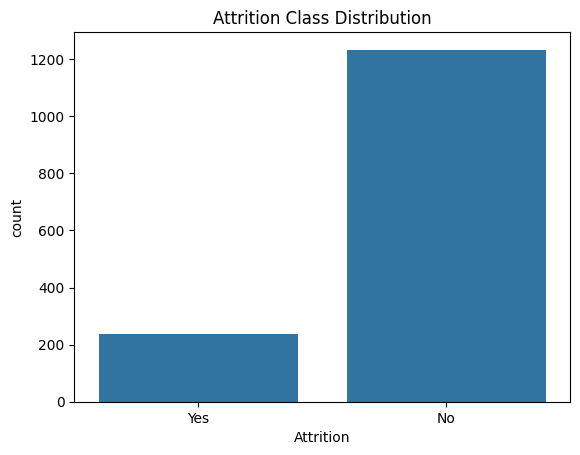

In [10]:
# 2. Load and Explore Dataset
from load_data import load_attrition_data
df = load_attrition_data()
print('Shape:', df.shape)
display(df.head())
print(df.describe(include='all'))
print('Class distribution:')
print(df['Attrition'].value_counts())
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Class Distribution')
plt.show()

In [18]:
# 3. Preprocess Data Using Modular Function
# Use the complete preprocessing pipeline from our module
df_processed = preprocess_attrition_data(df)
print("Data preprocessing completed!")
print(f"Processed data shape: {df_processed.shape}")
display(df_processed.head())

Data preprocessing completed!
Processed data shape: (1470, 51)


,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Attrition_bin,OverTime_bin,Gender_bin
0,0.446350,0.742527,-1.010909,2,-1.701283,-0.660531,1.383138,0.379672,-0.057788,1.153254,...,False,False,False,False,False,True,False,1,1.591746,-1.224745
1,1.322365,-1.297775,-0.147150,1,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,...,False,False,False,False,True,False,False,0,-0.628241,0.816497
2,0.008343,1.414363,-0.887515,2,-1.696298,1.169781,1.284725,-1.026167,-0.961486,0.246200,...,True,False,False,False,False,False,False,1,1.591746,0.816497
3,-0.429664,1.461466,-0.764121,4,-1.694636,1.169781,-0.486709,0.379672,-0.961486,0.246200,...,False,False,False,False,True,False,False,0,1.591746,-1.224745
4,-1.086676,-0.524295,-0.887515,1,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,...,True,False,False,False,False,False,False,0,-0.628241,0.816497


In [4]:
# 4. Handle Class Imbalance
# Use only the processed features (no original categorical columns)
X = df_processed.drop(columns=['Attrition_bin'])
y = df_processed['Attrition_bin']
print_class_distribution(y, label='Before SMOTE')
X_bal, y_bal = balance_with_smote(X, y)
print_class_distribution(y_bal, label='After SMOTE')

Before SMOTE: {1: 237, 0: 1233}
After SMOTE: {1: 1233, 0: 1233}
After SMOTE: {1: 1233, 0: 1233}


In [19]:
# 6. Complete Modeling and Analysis Workflow
# Use modular functions for data preparation and training

# Split features and target
X = df_processed.drop(columns=['Attrition_bin'])
y = df_processed['Attrition_bin']

print_class_distribution(y, label='Before SMOTE')

# Apply SMOTE for class balance
X_bal, y_bal = balance_with_smote(X, y)
print_class_distribution(y_bal, label='After SMOTE')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Print performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Before SMOTE: {1: 237, 0: 1233}
After SMOTE: {1: 1233, 0: 1233}
Train shape: (1972, 50), Test shape: (494, 50)

Model Performance:
Accuracy: 0.9049
ROC AUC: 0.9620

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       247
           1       0.93      0.87      0.90       247

    accuracy                           0.90       494
   macro avg       0.91      0.90      0.90       494
weighted avg       0.91      0.90      0.90       494


Model Performance:
Accuracy: 0.9049
ROC AUC: 0.9620

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       247
           1       0.93      0.87      0.90       247

    accuracy                           0.90       494
   macro avg       0.91      0.90      0.90       494
weighted avg       0.91      0.90      0.90       494



C:\Users\ricar\AppData\Local\Temp\ipykernel_12084\2212100928.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')


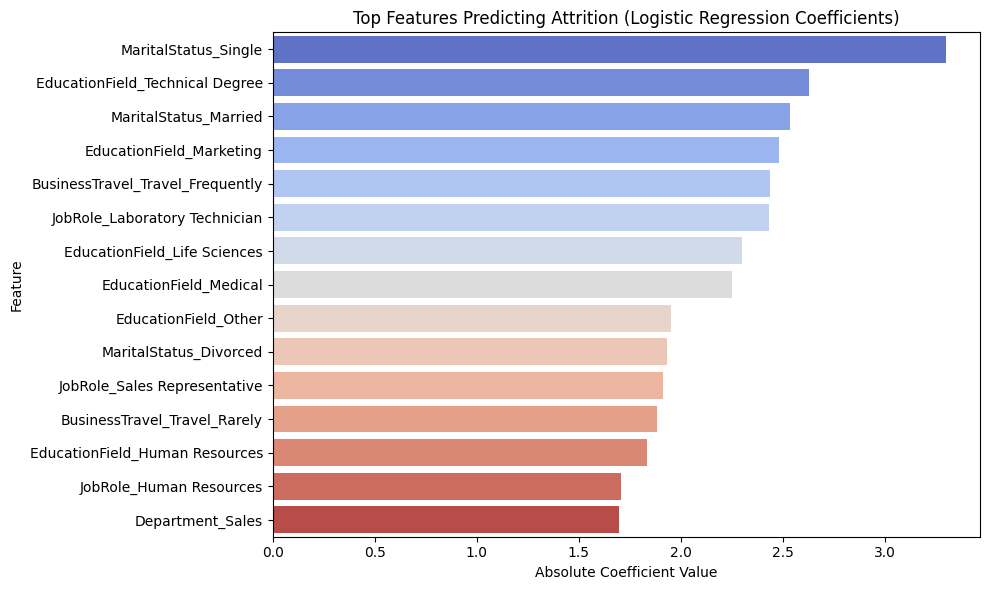

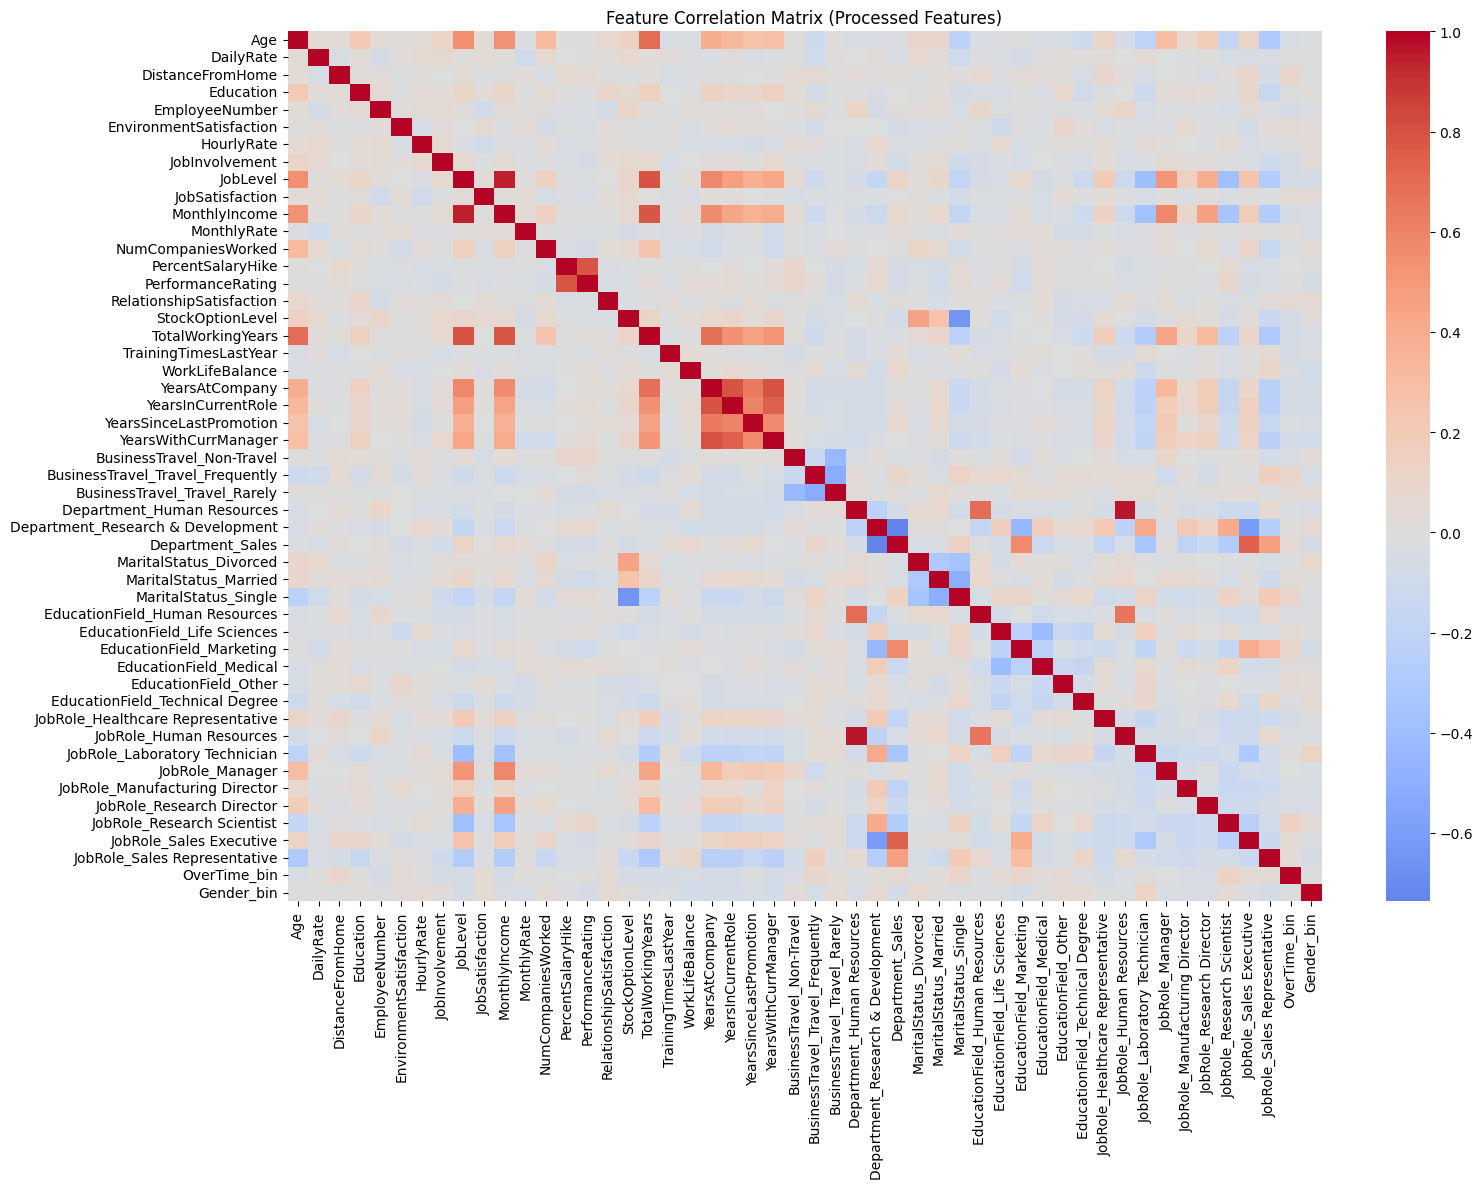

C:\Users\ricar\AppData\Local\Temp\ipykernel_12084\2212100928.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pair_values, y=pair_labels, palette='coolwarm')


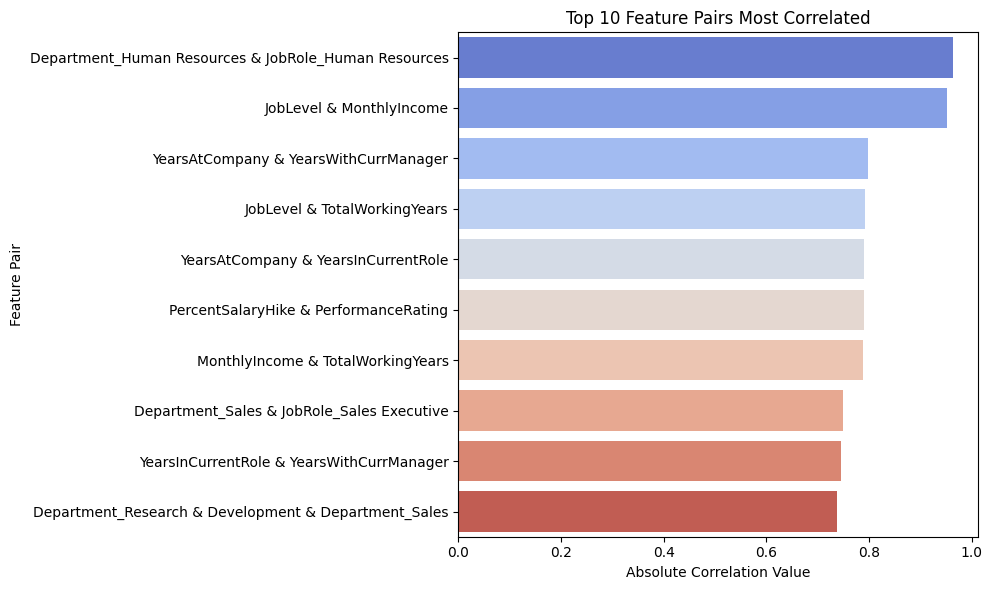

Analysis completed with modular approach!


In [20]:
# 7. Visualizations and Feature Analysis
# Create visualizations with meaningful feature names

# Feature importance visualization
feature_importance = pd.Series(logreg.coef_[0], index=X_train.columns)
top_features = feature_importance.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')
plt.title('Top Features Predicting Attrition (Logistic Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Correlation Matrix Heatmap
corr_matrix = X_train.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix (Processed Features)')
plt.tight_layout()
plt.show()

# Top 10 Feature Pairs Most Correlated
pairs = []
for i, feat1 in enumerate(corr_matrix.columns):
    for j, feat2 in enumerate(corr_matrix.columns):
        if i < j:
            pair_corr = corr_matrix.loc[feat1, feat2]
            pairs.append(((feat1, feat2), abs(pair_corr)))

pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
top_10_pairs = pairs_sorted[:10]
pair_labels = [f'{a} & {b}' for (a, b), _ in top_10_pairs]
pair_values = [v for (_, v) in top_10_pairs]

plt.figure(figsize=(10, 6))
sns.barplot(x=pair_values, y=pair_labels, palette='coolwarm')
plt.title('Top 10 Feature Pairs Most Correlated')
plt.xlabel('Absolute Correlation Value')
plt.ylabel('Feature Pair')
plt.tight_layout()
plt.show()

print("Analysis completed with modular approach!")